Assumptions: 
1. The first assumption is that each input time series will be of the same length.
2. All of the time series we receive as inputs should reflect the same underlying phenomenon.
3. There is no lagged autocorrelation between the series, or at least that lagged autocorrelation is not a significant factor.

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns

import matplotlib.pyplot as plt
from read_data import loadData
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

In [5]:
data_train, testDatasets, expectedRulDatasets = loadData()

In [6]:
drop_col = ['setting_1', 'setting_2', 'setting_3'] 
data_clean = [data.drop(columns = drop_col) for data in data_train]

In [7]:
df_full = pd.DataFrame()
for i in range(4):
    df_full =pd.concat([df_full, data_clean[i]])

In [8]:
df_copy = df_full.copy()

In [9]:
temp_cols = ['Fan_inlet_temperature_R', 'LPC_outlet_temperature_R', 'HPC_outlet_temperature_R', 'LPT_outlet_temperature_R']
rpm_cols = ['Physical_fan_speed_rpm', 'Physical_core_speed_rpm', 'Corrected_fan_speed_rpm', 'Corrected_core_speed_rpm']
press_cols = ['bypass_duct_pressure_psia', 'HPC_outlet_pressure_psia','Engine_pressure_ratioP50_P2', 'HPC_outlet_Static_pressure_psia']
air_flow_cols = ['High_pressure_turbines_Cool_air_flow', 'Low_pressure_turbines_Cool_air_flow']

In [10]:
df_all = df_copy[temp_cols]
# df_all = df_copy[air_flow_cols]

In [11]:
# series = [y for x, y in df_all.groupby("series_key", as_index=False)]
series = [df_all[col] for col in df_all.columns.drop('engine', errors='ignore')]
num_series = len(series)
l = len(series[0])

In [12]:
# test1 = series_segments = [np.array_split(series[x], (l // 7)) for x in range(num_series)]

In [13]:
series_segments = [np.array_split(series[x], (l // 7)) for x in range(num_series)]
num_segments = len(series_segments[0])

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [14]:
num_series, l, num_segments

(4, 160359, 22908)

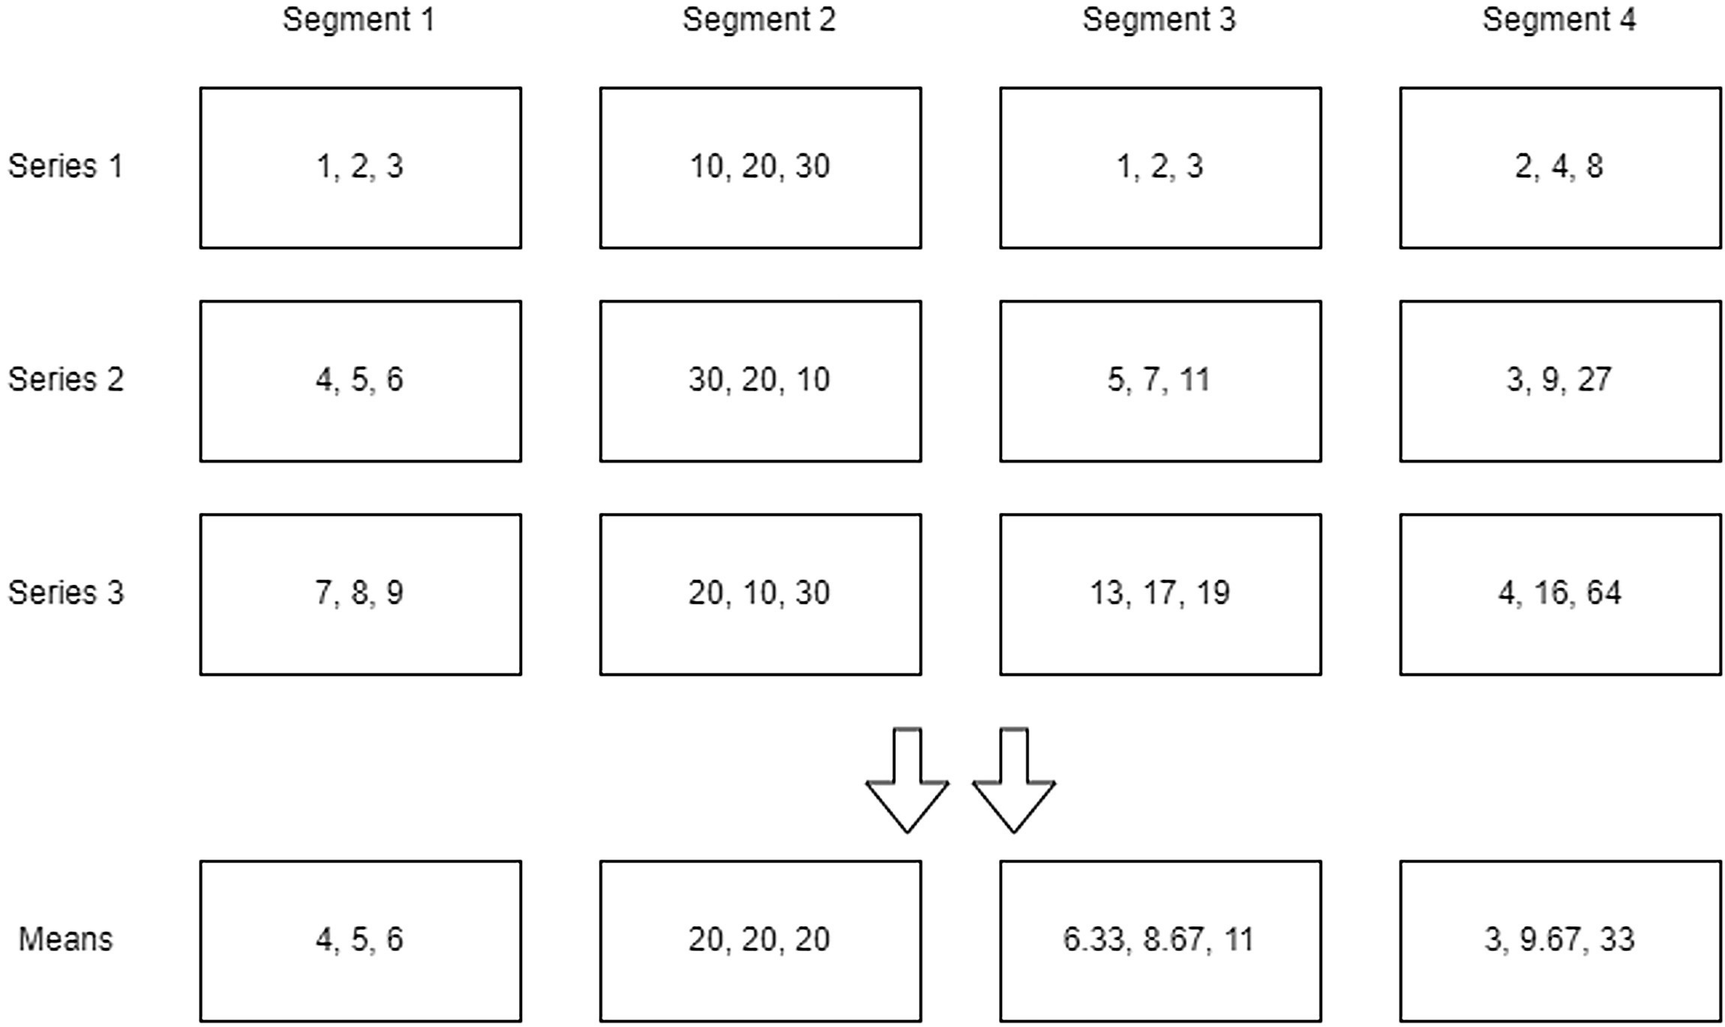

In [15]:
def generate_segment_means(series_segments, num_series, num_segments):
  '''
  Generating mean row wise for as above
  '''
  means = []
  for j in range(num_segments):
    C = [series_segments[i][j] for i in range(num_series)] # Taking all row values in each segment
    means.append([sum(x)/num_series for x in zip(*C)]) # Taking the mean of each row.
  return means 

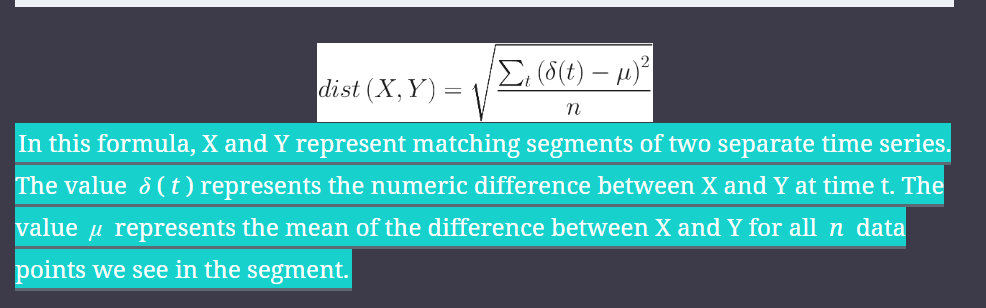

In [16]:
def diffstd(s1v, s2v):
    '''
    Both will be 1D vector of length one segment. 
    s1v: Segment for which we are doing the difference.
    s2v: Here the segment mean is row wise mean so each element in the segment has a mean value here the mean is mean of all the column 
    values for a specific row.
    '''
    dt = [x1 - x2 for (x1, x2) in zip(s1v, s2v)]
    n = len(s1v)
    mu = np.mean(dt)
    diff2 = [(d-mu)**2 for d in dt]
    return (np.sum(diff2)/n)**0.5

def check_diffstd(series_segments, segment_means, num_series, num_segments):
    '''
    diffstd_distance: It has the standard deviation of the difference of each element in the segment 
    '''
    for i in range(num_series): #22
        for j in range(num_segments): #22908
            series_segments[i][j]['segment_number'] = j
            series_segments[i][j]['diffstd_distance'] = diffstd(series_segments[i][j], segment_means[j])
    return series_segments

In [17]:
segment_means = generate_segment_means(series_segments, num_series, num_segments)
#len(test1), len(test1[0]), len(test1[0][0]),  len(segment_means), len(segment_means[0]), num_series, num_segments
segments_diffstd = check_diffstd(series_segments, segment_means, num_series, num_segments)

If the segments_diffstd is equal to 0, it means that the two segments do not diverge in behavior at all: when one moves up, the other moves up in exactly the same way; when one moves down, the other moves down in exactly the same way. Any segments_diffstd above 0 indicates some amount of difference in behavior. In case of two datasets moving in opposite directions: one is slowly trending upward and the other slowly trending downward causes DIFFSTD value to be above 0, but if those trends are small, DIFFSTD will be fairly small.

In [18]:
# len(segments_diffstd), len(segments_diffstd[0]),len(segments_diffstd[0][0]), segments_diffstd[2][0].name

In [19]:
len([segments_diffstd[0][i]['diffstd_distance'] for i in range(len(segments_diffstd[0]))])

22908

In [20]:
df_diff = pd.DataFrame()
for i in range(len(segments_diffstd)): #num of columns
    col = segments_diffstd[i][0].name
    print(col)
    df_diff[col] = [segments_diffstd[i][j]['diffstd_distance'] for j in range(len(segments_diffstd[i]))]

Fan_inlet_temperature_R
LPC_outlet_temperature_R
HPC_outlet_temperature_R
LPT_outlet_temperature_R


Difference of each segement in each column

In [21]:
sensitivity_score = 100

In [22]:
for i, col in enumerate(df_diff.columns):
    diffstd_mean = df_diff[col].mean() # Taking mean of diffstd values 
    diffstd_sensitivity_threshold = diffstd_mean + ((1.5 - (sensitivity_score / 100.0)) * diffstd_mean)
    df_diff[f'{col}_anomaly_score'] = (df_diff[col] - diffstd_sensitivity_threshold) / diffstd_sensitivity_threshold
#   return (pd.concat(series), diagnostics)

In [23]:
max_fraction_anomalies = 0.2

 For each series, it calculates the maximum anomaly score threshold "max_fraction_anomaly_scores". This threshold is determined by taking a quantile of the "anomaly_score" column. The quantile is computed by subtracting max_fraction_anomalies (a fraction representing the maximum proportion of anomalies allowed) from 1.0. Essentially, it sets a threshold so that only a certain fraction of the data points are considered anomalies.

In [24]:
max_fraction_anomaly_scores = [np.quantile(df_diff[col], 1.0 - max_fraction_anomalies) for col in df_diff.columns if col.endswith("anomaly_score")]
sensitivity_thresholds = [max(0.01, mfa) for mfa in max_fraction_anomaly_scores]

In [25]:
df_anomaly = df_diff[[col for col in df_diff.columns if col.endswith("anomaly_score")]]
df_final = df_all.drop(columns = ['engine'], errors='ignore')

In [26]:
df_repeated = pd.DataFrame(np.repeat(df_anomaly.values, 7, axis=0), columns=df_anomaly.columns)

In [27]:
df_result = pd.concat([df_final[:len(df_repeated)].reset_index(drop = True) ,df_repeated.reset_index(drop = True)], axis=1)

In [28]:
sens_dict = {}
for i, col in enumerate(df_result.filter(like = 'anomaly').columns):
    sens_dict[col] = sensitivity_thresholds[i]

In [29]:
df_result['pred_label'] = 0

In [30]:
for col in df_result.filter(like = 'anomaly').columns:
    for i in range(len(df_result)):
        if df_result.loc[i, col] > sens_dict[col]:
            df_result.loc[i, 'pred_label'] = 1

In [31]:
df_result['pred_label'].value_counts()

pred_label
0    118888
1     41468
Name: count, dtype: int64

In [32]:
def add_label(df_all, max_perc):
    df_all['actual_label'] = 0
    for engine in list(set(df_all['engine'])):
        max_cycle = df_all[df_all['engine'] == engine]['cycle'].max() 
        condition = (df_all['engine'] == engine) & (df_all['cycle'] > max_cycle*max_perc)
        df_all.loc[condition, 'actual_label'] = 1
    df_all = df_all.fillna(0)
    return df_all

In [33]:
df_copy = add_label(df_copy, 0.9)

Temperature_report

In [34]:
df_result['pred_label'].to_csv("sd_temperature_result.csv", index=False)

In [35]:
report = classification_report(df_copy['actual_label'][:len(df_result)], df_result['pred_label'])
print(report)

              precision    recall  f1-score   support

           0       0.95      0.74      0.84    152410
           1       0.06      0.31      0.10      7946

    accuracy                           0.72    160356
   macro avg       0.51      0.53      0.47    160356
weighted avg       0.91      0.72      0.80    160356



In [38]:
report = classification_report(df_copy['actual_label'][:len(df_result)], df_result['pred_label'])
print(report)

              precision    recall  f1-score   support

           0       0.95      0.74      0.84    152410
           1       0.06      0.31      0.10      7946

    accuracy                           0.72    160356
   macro avg       0.51      0.53      0.47    160356
weighted avg       0.91      0.72      0.80    160356



rpm

In [33]:
df_result['pred_label'].to_csv("sd_rpm_result.csv", index=False)

In [34]:
report = classification_report(df_copy['actual_label'][:len(df_result)], df_result['pred_label'])
print(report)

              precision    recall  f1-score   support

           0       0.95      0.66      0.78    152410
           1       0.06      0.39      0.10      7946

    accuracy                           0.65    160356
   macro avg       0.51      0.53      0.44    160356
weighted avg       0.91      0.65      0.75    160356



pressure

In [33]:
df_result['pred_label'].to_csv("sd_pressure_result.csv", index=False)

In [34]:
report = classification_report(df_copy['actual_label'][:len(df_result)], df_result['pred_label'])
print(report)

              precision    recall  f1-score   support

           0       0.95      0.79      0.86    152410
           1       0.06      0.25      0.09      7946

    accuracy                           0.76    160356
   macro avg       0.50      0.52      0.48    160356
weighted avg       0.91      0.76      0.82    160356



airflow

In [39]:
df_result['pred_label'].to_csv("sd_airflow_result.csv", index=False)

In [40]:
report = classification_report(df_copy['actual_label'][:len(df_result)], df_result['pred_label'])
print(report)

              precision    recall  f1-score   support

           0       0.95      0.80      0.87    152410
           1       0.06      0.22      0.09      7946

    accuracy                           0.77    160356
   macro avg       0.50      0.51      0.48    160356
weighted avg       0.91      0.77      0.83    160356



In [73]:
import os
csv_file = [file for file in os.listdir("./") if file.endswith(".csv")]

In [76]:
for i, file in enumerate(csv_file):
    print(file[0])

s
s
s
s


In [77]:
df_anom = pd.DataFrame()
for i, file in enumerate(csv_file):
    print(file[3:-4])
    df_anom[file[3:-4]] = pd.read_csv(file)['pred_label'] 
    # df_anom[file[0][3:-4]] = pd.concat([df_anom, pd.read_csv(file)], axis= 1)

airflow_result
pressure_result
rpm_result
temperature_result


In [80]:
df_anom['is_anomaly'] = 0

In [81]:
for i in range(len(df_anom)):
    if df_anom.loc[i].any():
        df_anom.loc[i, 'is_anomaly'] = 1

For all sensors

In [83]:
report = classification_report(df_copy['actual_label'][:len(df_result)], df_anom['is_anomaly'])
print(report)

              precision    recall  f1-score   support

           0       0.96      0.62      0.75    152410
           1       0.06      0.44      0.10      7946

    accuracy                           0.61    160356
   macro avg       0.51      0.53      0.43    160356
weighted avg       0.91      0.61      0.72    160356



In [93]:
df_cyc_ano = pd.concat([df_copy['cycle'][:len(df_anom)].reset_index(drop=True), df_anom['is_anomaly']],axis = 1)

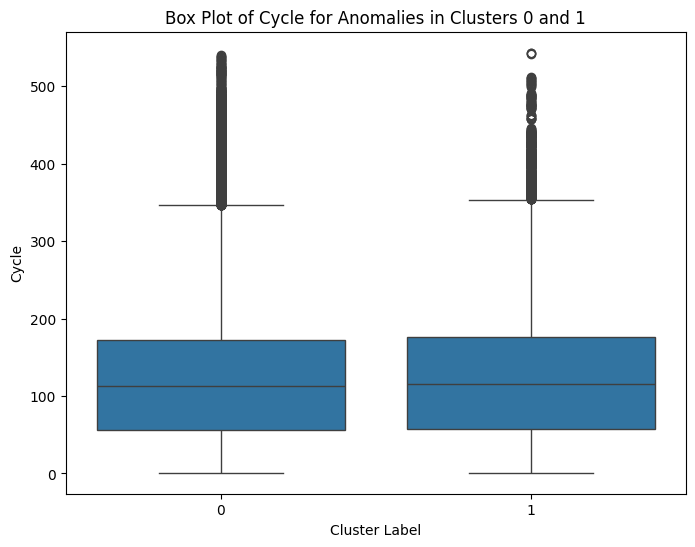

In [94]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_cyc_ano, x='is_anomaly', y='cycle')
plt.title('Box Plot of Cycle for Anomalies in Clusters 0 and 1')
plt.xlabel('Cluster Label')
plt.ylabel('Cycle')
plt.show()